In [1]:
import numpy as np
import tensorflow as tf
import gzip
import pickle
import sys
import copy
import os.path
import pdb
import re
from ddm.run_split import SplitMnistGenerator
from ddm.run_not import NotMnistGenerator
from ddm.alg.cla_models_multihead import MFVI_IBP_NN, Vanilla_NN
from ddm.alg.utils import get_scores, concatenate_results
from ddm.alg.vcl import run_vcl
from copy import deepcopy

from bayes_opt import BayesianOptimization

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

W0821 20:05:56.469430 140352637986624 deprecation_wrapper.py:119] From /home/skessler/Projects/IBP_BNN/ddm/alg/cla_models_multihead.py:9: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0821 20:05:56.470671 140352637986624 deprecation_wrapper.py:119] From /home/skessler/Projects/IBP_BNN/ddm/alg/cla_models_multihead.py:13: The name tf.set_random_seed is deprecated. Please use tf.compat.v1.set_random_seed instead.



# Split MNIST

In [2]:
hidden_size = [100]
batch_size = 128
no_epochs = 100
alpha0 = 1.0
tau0=1.0 # initial temperature
ANNEAL_RATE=0.000
MIN_TEMP=0.1
ibp_samples = 10

# Run vanilla VCL
tf.set_random_seed(12)
np.random.seed(1)

ibp_acc = np.array([])

coreset_size = 0
val = True
data_gen = SplitMnistGenerator(val)
single_head=False
in_dim, out_dim = data_gen.get_dims()
x_testsets, y_testsets = [], []
x_valsets, y_valsets = [], []
for task_id in range(data_gen.max_iter):
    
    tf.reset_default_graph()
    if val:
        x_train, y_train, x_test, y_test, x_val, y_val = data_gen.next_task()
        x_valsets.append(x_val)
        y_valsets.append(y_val)
    else:    
        x_train, y_train, x_test, y_test = data_gen.next_task()
    x_testsets.append(x_test)
    y_testsets.append(y_test)

    # Set the readout head to train
    head = 0 if single_head else task_id
    bsize = x_train.shape[0] if (batch_size is None) else batch_size
    
    # Train network with maximum likelihood to initialize first model
    if task_id == 0:
        ml_model = Vanilla_NN(in_dim, hidden_size, out_dim, x_train.shape[0])
        ml_model.train(x_train, y_train, task_id, no_epochs, bsize)
        mf_weights = ml_model.get_weights()
        mf_variances = None
        mf_betas = None
        ml_model.close_session()

    # Train on non-coreset data
    mf_model = MFVI_IBP_NN(in_dim, hidden_size, out_dim, x_train.shape[0], num_ibp_samples=ibp_samples,
                           prev_means=mf_weights, 
                           prev_log_variances=mf_variances, prev_betas=mf_betas,alpha0=alpha0,
                           learning_rate=0.01, lambda_1=tau0, lambda_2=1.0, no_pred_samples=100)
    mf_model.train(x_train, y_train, head, no_epochs, bsize,
                   anneal_rate=ANNEAL_RATE, min_temp=MIN_TEMP)
    mf_weights, mf_variances, mf_betas = mf_model.get_weights()

    acc = get_scores(mf_model, x_valsets, y_valsets, single_head)
    ibp_acc = concatenate_results(acc, ibp_acc)
    
    mf_model.close_session()
    
ibp_acc

W0820 10:28:14.920098 140357229651776 deprecation_wrapper.py:119] From /home/skessler/Projects/IBP_BNN/ddm/alg/cla_models_multihead.py:56: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0820 10:28:14.928613 140357229651776 deprecation_wrapper.py:119] From /home/skessler/Projects/IBP_BNN/ddm/alg/cla_models_multihead.py:177: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0820 10:28:15.041888 140357229651776 deprecation_wrapper.py:119] From /home/skessler/Projects/IBP_BNN/ddm/alg/cla_models_multihead.py:61: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.

W0820 10:28:15.235116 140357229651776 deprecation_wrapper.py:119] From /home/skessler/Projects/IBP_BNN/ddm/alg/cla_models_multihead.py:65: The name tf.global_variables_initializer is deprecated. Please use tf.compat.v1.global_variables_initializer instead.



Epoch: 0001 cost= 0.054045935
Epoch: 0006 cost= 0.000989384
Epoch: 0011 cost= 0.000217877
Epoch: 0016 cost= 0.000095243
Epoch: 0021 cost= 0.000053343
Epoch: 0026 cost= 0.000032177
Epoch: 0031 cost= 0.000020990
Epoch: 0036 cost= 0.000013812
Epoch: 0041 cost= 0.000010000
Epoch: 0046 cost= 0.000007089
Epoch: 0051 cost= 0.000005146
Epoch: 0056 cost= 0.000003880
Epoch: 0061 cost= 0.000002915
Epoch: 0066 cost= 0.000002253
Epoch: 0071 cost= 0.000001736
Epoch: 0076 cost= 0.000001336
Epoch: 0081 cost= 0.000001051
Epoch: 0086 cost= 0.000000806
Epoch: 0091 cost= 0.000000640
Epoch: 0096 cost= 0.000000494


W0820 10:28:39.117458 140357229651776 deprecation.py:323] From /home/skessler/Projects/IBP_BNN/ddm/alg/cla_models_multihead.py:567: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


Optimization Finished!
(1, ?, 100)
<unknown>


W0820 10:28:39.556495 140357229651776 deprecation.py:323] From /home/skessler/Projects/IBP_BNN/ddm/alg/cla_models_multihead.py:520: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


(1, ?, 100)
<unknown>
(1, ?, 100)
<unknown>


W0820 10:28:40.307626 140357229651776 deprecation.py:323] From /home/skessler/anaconda2/envs/py36/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0820 10:28:42.101294 140357229651776 deprecation_wrapper.py:119] From /home/skessler/Projects/IBP_BNN/ddm/alg/cla_models_multihead.py:527: The name tf.train.Saver is deprecated. Please use tf.compat.v1.train.Saver instead.

W0820 10:28:42.166632 140357229651776 deprecation_wrapper.py:119] From /home/skessler/Projects/IBP_BNN/ddm/alg/cla_models_multihead.py:662: The name tf.summary.scalar is deprecated. Please use tf.compat.v1.summary.scalar instead.

W0820 10:28:42.207280 140357229651776 deprecation_wrapper.py:119] From /home/skessler/Projects/IBP_BNN/ddm/alg/cla_models_multihead.py:671: The name tf

_Z: (1, ?, 100)


W0820 10:28:42.556347 140357229651776 deprecation_wrapper.py:119] From /home/skessler/Projects/IBP_BNN/ddm/alg/cla_models_multihead.py:955: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



Epoch: 0001 train cost= 22.979616349
Epoch: 0006 train cost= 7.847686078
Epoch: 0011 train cost= 4.484062356
Epoch: 0016 train cost= 4.284478007
Epoch: 0021 train cost= 4.183985552
Epoch: 0026 train cost= 4.085030877
Epoch: 0031 train cost= 4.028940247
Epoch: 0036 train cost= 3.973704306
Epoch: 0041 train cost= 3.931877205
Epoch: 0046 train cost= 3.905022799
Epoch: 0051 train cost= 3.867956587
Epoch: 0056 train cost= 3.860971652
Epoch: 0061 train cost= 3.825531069
Epoch: 0066 train cost= 3.800201376
Epoch: 0071 train cost= 3.808827998
Epoch: 0076 train cost= 3.780617613
Epoch: 0081 train cost= 3.751397926
Epoch: 0086 train cost= 3.753835310
Epoch: 0091 train cost= 3.723489175
Epoch: 0096 train cost= 3.734567102
Optimization Finished!
(1, ?, 100)
<unknown>
(1, ?, 100)
<unknown>
(1, ?, 100)
<unknown>
_Z: (1, ?, 100)
Epoch: 0001 train cost= 2.041086149
Epoch: 0006 train cost= 1.672260149
Epoch: 0011 train cost= 1.626302651
Epoch: 0016 train cost= 1.594602039
Epoch: 0021 train cost= 1.5776

array([[0.99756691,        nan,        nan,        nan,        nan],
       [0.52895377, 0.97425743,        nan,        nan,        nan],
       [0.62871046, 0.87722772, 0.971549  ,        nan,        nan],
       [0.54257908, 0.79158416, 0.97312961, 0.98833252,        nan],
       [0.52652068, 0.61485149, 0.95574289, 0.98492951, 0.97664975]])

In [4]:
# Run Vanilla VCL
tf.reset_default_graph()
tf.set_random_seed(12)
np.random.seed(1)
hidden_size = [10]
coreset_size = 0

data_gen = SplitMnistGenerator(val=True)
vcl_result = run_vcl(hidden_size, no_epochs, data_gen, 
                              lambda a: a, coreset_size, batch_size, single_head, val=True)
print(vcl_result)

Epoch: 0001 cost= 0.260041745
Epoch: 0006 cost= 0.005151312
Epoch: 0011 cost= 0.002609195
Epoch: 0016 cost= 0.001677913
Epoch: 0021 cost= 0.001073658
Epoch: 0026 cost= 0.000651595
Epoch: 0031 cost= 0.000435936
Epoch: 0036 cost= 0.000280965
Epoch: 0041 cost= 0.000201473
Epoch: 0046 cost= 0.000137499
Epoch: 0051 cost= 0.000096778
Epoch: 0056 cost= 0.000071720
Epoch: 0061 cost= 0.000053018
Epoch: 0066 cost= 0.000040704
Epoch: 0071 cost= 0.000031381
Epoch: 0076 cost= 0.000023424
Epoch: 0081 cost= 0.000018736
Epoch: 0086 cost= 0.000013911
Epoch: 0091 cost= 0.000010898
Epoch: 0096 cost= 0.000008418
Optimization Finished!
Epoch: 0001 cost= 1.846670676
Epoch: 0006 cost= 1.689760324
Epoch: 0011 cost= 1.536770825
Epoch: 0016 cost= 1.385002039
Epoch: 0021 cost= 1.234384163
Epoch: 0026 cost= 1.086196825
Epoch: 0031 cost= 0.940980348
Epoch: 0036 cost= 0.800019918
Epoch: 0041 cost= 0.664992467
Epoch: 0046 cost= 0.537858195
Epoch: 0051 cost= 0.420864664
Epoch: 0056 cost= 0.315800496
Epoch: 0061 cost=

In [7]:
np.max(data_gen.X_test)

0.99609375

In [8]:
np.min(data_gen.X_test)

0.0

In [ ]:
# # Run IBP VCL
# tf.reset_default_graph()
# tf.set_random_seed(12)
# np.random.seed(1)
# coreset_size = 0

# hidden_size = [50]
# batch_size = 128
# no_epochs = 100
# alpha0 = 5.0
# tau0=0.1 # initial temperature
# temp_prior=1.0
# ANNEAL_RATE=0.000
# MIN_TEMP=0.1
# single_head=False

# # data_gen = SplitMnistGenerator()
# # vcl_ibp_result = vcl.run_vcl_ibp(hidden_size=hidden_size, no_epochs=no_epochs, data_gen=data_gen,
# #                                   batch_size=batch_size, single_head=single_head, alpha0=alpha0,
# #                                   learning_rate=0.01, temp_prior=temp_prior, no_pred_samples=100,
# #                                   tau0=tau0, tau_anneal_rate=ANNEAL_RATE, tau_min=MIN_TEMP)
# # print(vcl_ibp_result)

In [ ]:
_ibp_acc = np.nanmean(ibp_acc, 1)
_vcl_result = np.nanmean(vcl_result, 1)

In [ ]:
_vcl_result

In [ ]:
plt.rc('text', usetex=True)
#plt.rc('font', family='serif')

fig = plt.figure(figsize=(7,3))
ax = plt.gca()
plt.plot(np.arange(len(_ibp_acc))+1, _ibp_acc, label='VCL + IBP', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result, label='VCL', marker='o')
ax.set_xticks(range(1, len(_ibp_acc)+1))
ax.set_ylabel('Average accuracy')
ax.set_xlabel('\# tasks')
ax.legend()
fig.show()

# Not MNIST

In [4]:
hidden_size = [100]
batch_size = 128
no_epochs = 200
ibp_samples = 10

# Run vanilla VCL
tf.set_random_seed(12)
np.random.seed(1)

ibp_acc = np.array([])

coreset_size = 0
data_gen = NotMnistGenerator()
single_head=False
in_dim, out_dim = data_gen.get_dims()
x_testsets, y_testsets = [], []
#x_valsets, y_valsets = [], []
for task_id in range(data_gen.max_iter):
    
    tf.reset_default_graph()
    x_train, y_train, x_test, y_test, _, _ = data_gen.next_task()
    #x_valsets.append(x_val)
    #y_valsets.append(y_val)
    x_testsets.append(x_test)
    y_testsets.append(y_test)

    # Set the readout head to train
    head = 0 if single_head else task_id
    bsize = x_train.shape[0] if (batch_size is None) else batch_size
    
    # Train network with maximum likelihood to initialize first model
    if task_id == 0:
        ml_model = Vanilla_NN(in_dim, hidden_size, out_dim, x_train.shape[0])
        ml_model.train(x_train, y_train, task_id, no_epochs, bsize)
        mf_weights = ml_model.get_weights()
        mf_variances = None
        mf_betas = None
        ml_model.close_session()

    # Train on non-coreset data
    mf_model = MFVI_IBP_NN(in_dim, hidden_size, out_dim, x_train.shape[0], num_ibp_samples=ibp_samples,
                           prev_means=mf_weights, 
                           prev_log_variances=mf_variances, prev_betas=mf_betas, 
                           alpha0=5., beta0=1.,
                           learning_rate=0.001, lambda_1=1.0, lambda_2=1.0, no_pred_samples=100)

    mf_model.train(x_train, y_train, head, no_epochs, bsize,
                   anneal_rate=0.0, min_temp=1.0)
    mf_weights, mf_variances, mf_betas = mf_model.get_weights()

    acc = get_scores(mf_model, x_testsets, y_testsets, single_head)
    ibp_acc = concatenate_results(acc, ibp_acc)
    
    mf_model.close_session()
    
ibp_acc

Epoch: 0001 cost= 0.146469993
Epoch: 0006 cost= 0.051735276
Epoch: 0011 cost= 0.028104113
Epoch: 0016 cost= 0.015942755
Epoch: 0021 cost= 0.015865596
Epoch: 0026 cost= 0.011969231
Epoch: 0031 cost= 0.009667647
Epoch: 0036 cost= 0.009111372
Epoch: 0041 cost= 0.008909420
Epoch: 0046 cost= 0.008711578
Epoch: 0051 cost= 0.010608444
Epoch: 0056 cost= 0.008632005
Epoch: 0061 cost= 0.011303626
Epoch: 0066 cost= 0.006225984
Epoch: 0071 cost= 0.005884801
Epoch: 0076 cost= 0.005166127
Epoch: 0081 cost= 0.006437723
Epoch: 0086 cost= 0.006132824
Epoch: 0091 cost= 0.006260679
Epoch: 0096 cost= 0.006746725
Epoch: 0101 cost= 0.005560117
Epoch: 0106 cost= 0.005934628
Epoch: 0111 cost= 0.005584506
Epoch: 0116 cost= 0.003656060
Epoch: 0121 cost= 0.004826352
Epoch: 0126 cost= 0.004615627
Epoch: 0131 cost= 0.004941612
Epoch: 0136 cost= 0.003932573
Epoch: 0141 cost= 0.005345335
Epoch: 0146 cost= 0.006734761
Epoch: 0151 cost= 0.005482487
Epoch: 0156 cost= 0.004824669
Epoch: 0161 cost= 0.005427741
Epoch: 016

W0821 20:13:43.979037 140352637986624 deprecation.py:323] From /home/skessler/Projects/IBP_BNN/ddm/alg/cla_models_multihead.py:575: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


Optimization Finished!
(1, ?, 100)
<unknown>


W0821 20:13:44.308247 140352637986624 deprecation.py:323] From /home/skessler/Projects/IBP_BNN/ddm/alg/cla_models_multihead.py:528: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


(1, ?, 100)
<unknown>
(1, ?, 100)
<unknown>


W0821 20:13:45.146842 140352637986624 deprecation.py:323] From /home/skessler/anaconda2/envs/py36/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0821 20:13:46.593549 140352637986624 deprecation_wrapper.py:119] From /home/skessler/Projects/IBP_BNN/ddm/alg/cla_models_multihead.py:535: The name tf.train.Saver is deprecated. Please use tf.compat.v1.train.Saver instead.

W0821 20:13:46.644495 140352637986624 deprecation_wrapper.py:119] From /home/skessler/Projects/IBP_BNN/ddm/alg/cla_models_multihead.py:670: The name tf.summary.scalar is deprecated. Please use tf.compat.v1.summary.scalar instead.

W0821 20:13:46.668156 140352637986624 deprecation_wrapper.py:119] From /home/skessler/Projects/IBP_BNN/ddm/alg/cla_models_multihead.py:680: The name tf

_Z: (1, ?, 100)


W0821 20:13:46.904784 140352637986624 deprecation_wrapper.py:119] From /home/skessler/Projects/IBP_BNN/ddm/alg/cla_models_multihead.py:965: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



Epoch: 0001 train cost= 5.202547515
Epoch: 0006 train cost= 3.581586042
Epoch: 0011 train cost= 2.206910697
Epoch: 0016 train cost= 1.116205960
Epoch: 0021 train cost= 0.593110222
Epoch: 0026 train cost= 0.485295451
Epoch: 0031 train cost= 0.425318644
Epoch: 0036 train cost= 0.385313988
Epoch: 0041 train cost= 0.355264273
Epoch: 0046 train cost= 0.336294629
Epoch: 0051 train cost= 0.322879804
Epoch: 0056 train cost= 0.313448984
Epoch: 0061 train cost= 0.306135205
Epoch: 0066 train cost= 0.301395781
Epoch: 0071 train cost= 0.297382401
Epoch: 0076 train cost= 0.295581180
Epoch: 0081 train cost= 0.292744761
Epoch: 0086 train cost= 0.290746831
Epoch: 0091 train cost= 0.290177066
Epoch: 0096 train cost= 0.288360518
Epoch: 0101 train cost= 0.287183318
Epoch: 0106 train cost= 0.286402736
Epoch: 0111 train cost= 0.284753941
Epoch: 0116 train cost= 0.283848950
Epoch: 0121 train cost= 0.284287527
Epoch: 0126 train cost= 0.284116088
Epoch: 0131 train cost= 0.281811037
Epoch: 0136 train cost= 0.28

array([[0.984 ,    nan,    nan,    nan,    nan],
       [0.9645, 0.9875,    nan,    nan,    nan],
       [0.958 , 0.971 , 0.978 ,    nan,    nan],
       [0.9585, 0.9575, 0.9605, 0.978 ,    nan],
       [0.883 , 0.935 , 0.8065, 0.969 , 0.9585]])

In [6]:
# Run Vanilla VCL
tf.reset_default_graph()
tf.set_random_seed(12)
np.random.seed(1)
hidden_size = [10]
coreset_size = 0

data_gen = NotMnistGenerator()
vcl_result = run_vcl(hidden_size, no_epochs, data_gen, 
                     lambda a: a, coreset_size, batch_size, single_head, val=True)
print(vcl_result)

Epoch: 0001 cost= 0.194894983
Epoch: 0006 cost= 0.096757376
Epoch: 0011 cost= 0.079385228
Epoch: 0016 cost= 0.067739842
Epoch: 0021 cost= 0.060180040
Epoch: 0026 cost= 0.052712276
Epoch: 0031 cost= 0.048527642
Epoch: 0036 cost= 0.044342909
Epoch: 0041 cost= 0.040176251
Epoch: 0046 cost= 0.035888922
Epoch: 0051 cost= 0.033815378
Epoch: 0056 cost= 0.030088093
Epoch: 0061 cost= 0.027864948
Epoch: 0066 cost= 0.025638432
Epoch: 0071 cost= 0.022936127
Epoch: 0076 cost= 0.021338913
Epoch: 0081 cost= 0.019360169
Epoch: 0086 cost= 0.020213691
Epoch: 0091 cost= 0.016724435
Epoch: 0096 cost= 0.014948512
Epoch: 0101 cost= 0.013673355
Epoch: 0106 cost= 0.013652850
Epoch: 0111 cost= 0.012843400
Epoch: 0116 cost= 0.011959156
Epoch: 0121 cost= 0.012440523
Epoch: 0126 cost= 0.012730863
Epoch: 0131 cost= 0.010156876
Epoch: 0136 cost= 0.011786172
Epoch: 0141 cost= 0.010874130
Epoch: 0146 cost= 0.011499197
Epoch: 0151 cost= 0.009101483
Epoch: 0156 cost= 0.008977741
Epoch: 0161 cost= 0.009146964
Epoch: 016

In [8]:
# Run Vanilla VCL
tf.reset_default_graph()
tf.set_random_seed(12)
np.random.seed(1)
hidden_size = [5]
coreset_size = 0

data_gen = NotMnistGenerator()
vcl_result_h5 = run_vcl(hidden_size, no_epochs, data_gen, 
                     lambda a: a, coreset_size, batch_size, single_head, val=True)
print(vcl_result_h5)

Epoch: 0001 cost= 0.211736251
Epoch: 0006 cost= 0.107794914
Epoch: 0011 cost= 0.096261189
Epoch: 0016 cost= 0.089602290
Epoch: 0021 cost= 0.084507436
Epoch: 0026 cost= 0.080454039
Epoch: 0031 cost= 0.076957272
Epoch: 0036 cost= 0.074719685
Epoch: 0041 cost= 0.071458950
Epoch: 0046 cost= 0.069443085
Epoch: 0051 cost= 0.067098836
Epoch: 0056 cost= 0.065269344
Epoch: 0061 cost= 0.062815753
Epoch: 0066 cost= 0.061346556
Epoch: 0071 cost= 0.060075689
Epoch: 0076 cost= 0.058046302
Epoch: 0081 cost= 0.056467461
Epoch: 0086 cost= 0.055744268
Epoch: 0091 cost= 0.054359862
Epoch: 0096 cost= 0.053127319
Epoch: 0101 cost= 0.051854244
Epoch: 0106 cost= 0.050908735
Epoch: 0111 cost= 0.049672897
Epoch: 0116 cost= 0.049877447
Epoch: 0121 cost= 0.048096809
Epoch: 0126 cost= 0.048598100
Epoch: 0131 cost= 0.046465958
Epoch: 0136 cost= 0.044872621
Epoch: 0141 cost= 0.044639408
Epoch: 0146 cost= 0.044706659
Epoch: 0151 cost= 0.042965389
Epoch: 0156 cost= 0.042411680
Epoch: 0161 cost= 0.042046499
Epoch: 016

In [11]:
# Run Vanilla VCL
tf.reset_default_graph()
tf.set_random_seed(12)
np.random.seed(1)
hidden_size = [50]
coreset_size = 0

data_gen = NotMnistGenerator()
vcl_result_h50 = run_vcl(hidden_size, no_epochs, data_gen, 
                     lambda a: a, coreset_size, batch_size, single_head, val=True)
print(vcl_result_h50)

Epoch: 0001 cost= 0.153718561
Epoch: 0006 cost= 0.061457908
Epoch: 0011 cost= 0.037431205
Epoch: 0016 cost= 0.022582043
Epoch: 0021 cost= 0.017541323
Epoch: 0026 cost= 0.012438207
Epoch: 0031 cost= 0.010182058
Epoch: 0036 cost= 0.009672760
Epoch: 0041 cost= 0.007883243
Epoch: 0046 cost= 0.007413055
Epoch: 0051 cost= 0.009715796
Epoch: 0056 cost= 0.007014894
Epoch: 0061 cost= 0.009667960
Epoch: 0066 cost= 0.007403898
Epoch: 0071 cost= 0.007036378
Epoch: 0076 cost= 0.006717535
Epoch: 0081 cost= 0.006098075
Epoch: 0086 cost= 0.007884045
Epoch: 0091 cost= 0.005445113
Epoch: 0096 cost= 0.007306467
Epoch: 0101 cost= 0.007086758
Epoch: 0106 cost= 0.004177887
Epoch: 0111 cost= 0.007087358
Epoch: 0116 cost= 0.003494912
Epoch: 0121 cost= 0.005541459
Epoch: 0126 cost= 0.005622239
Epoch: 0131 cost= 0.005170572
Epoch: 0136 cost= 0.004932709
Epoch: 0141 cost= 0.005369881
Epoch: 0146 cost= 0.005383066
Epoch: 0151 cost= 0.005779357
Epoch: 0156 cost= 0.004426445
Epoch: 0161 cost= 0.004463694
Epoch: 016

/home/skessler/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


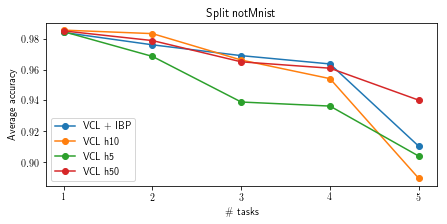

In [12]:
_ibp_acc = np.nanmean(ibp_acc, 1)
_vcl_result_h10 = np.nanmean(vcl_result, 1)
_vcl_result_h5 = np.nanmean(vcl_result_h5, 1)
_vcl_result_h50 = np.nanmean(vcl_result_h50, 1)
fig = plt.figure(figsize=(7,3))
ax = plt.gca()
plt.plot(np.arange(len(_ibp_acc))+1, _ibp_acc, label='VCL + IBP', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result_h10, label='VCL h10', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result_h5, label='VCL h5', marker='o')
plt.plot(np.arange(len(_vcl_result))+1, _vcl_result_h50, label='VCL h50', marker='o')
ax.set_xticks(range(1, len(_ibp_acc)+1))
ax.set_ylabel('Average accuracy')
ax.set_xlabel('\# tasks')
ax.set_title('Split notMnist')
ax.legend()
fig.show()